In [1]:
import pickle
with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
the_frontier_eddies = list(sample_data.keys())

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

In [3]:
def dopioe(nic, njc, r, u, v, X, Y):

    def find_root(x, y, degree=3):
        """Fit a degree-3 polynomial to (x, y) and return the real root closest to x's midpoint."""
        coeffs = np.polyfit(x, y, degree)
        roots = np.roots(np.poly1d(coeffs))
        real_roots = roots[np.isreal(roots)].real
        mid_x = x[len(x) // 2]
        return real_roots[np.argmin(np.abs(real_roots - mid_x))]
    
    def tangent_at_root(x, y, root_x, degree=3):
        coeffs = np.polyfit(x, y, degree)
        slope = np.polyval(np.polyder(coeffs), root_x)
        intercept = np.polyval(coeffs, root_x) - slope * root_x
        y_fit = np.polyval(coeffs, x)
        r2 = 1 - np.sum((y - y_fit)**2) / np.sum((y - np.mean(y))**2) if np.sum((y - np.mean(y))**2) != 0 else 1.0
        return slope, intercept, r2

    # Vertical profile along column njc
    u1 = u[nic - r: nic + r + 1, njc]
    v1 = v[nic - r: nic + r + 1, njc]
    x1 = X.T[nic - r: nic + r + 1, njc]
    y1 = Y.T[nic - r: nic + r + 1, njc]
    center_x = X.T[nic, njc]
    xx = x1 - center_x
    # Horizontal profile along row nic
    u2 = u[nic, njc - r: njc + r + 1]
    v2 = v[nic, njc - r: njc + r + 1]
    x2 = X.T[nic, njc - r: njc + r + 1]
    y2 = Y.T[nic, njc - r: njc + r + 1]
    center_y = Y.T[nic, njc]
    yy = y2 - center_y
    # Compute roots and tangents
    root_x = find_root(xx, v1)
    A1, A0, r2A = tangent_at_root(xx, u1, root_x)
    B1, B0, r2B = tangent_at_root(xx, v1, root_x)
    root_y = find_root(yy, u2)
    C1, C0, r2C = tangent_at_root(yy, u2, root_y)
    D1, D0, r2D = tangent_at_root(yy, v2, root_y)
    
    alpha = A0 if r2A > r2C else C0
    beta  = B0 if r2B > r2D else D0
    gamma = A1 if r2A > r2D else -D1
    
    q11 = B1 / 2
    q22 = -C1 / 2
    q12 = -gamma / 2
    denom = C1 * B1 + gamma**2
    if denom == 0:
        raise ZeroDivisionError("Denominator is zero.")
        
    x0 = - (alpha * gamma + beta * C1) / denom
    y0 = (beta * gamma - alpha * B1) / denom
    w = 2 * (q11 + q22)

    Q = np.array([[q11, q12], [q12, q22]])

    return x0 + center_x, y0 + center_y, w, Q


#### DOPIOE

In [34]:
df_DOPIOE = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'nic', 'njc', 'z', 'Depth', 'w', 'Q'])
for eddy in the_frontier_eddies:

    var = 1 if eddies[eddy].iloc[0]['Vort'] > 0 else -1 # 1 for anti-cyclone

    for t in range(30): 

        U = sample_data[eddy]['T'+str(t)]['U']
        V = sample_data[eddy]['T'+str(t)]['V']
        
        x, y = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
        X, Y, dx = *np.meshgrid(x, y), x[1]-x[0]

        xc_pre, yc_pre = 0, 0
        nic, njc = U.shape[0]//2, U.shape[1]//2
        r = 5
        for depth_lvl in range(25):

            if not (r <= nic < U.shape[0] - r and r <= njc < U.shape[1] - r):
                break

            u, v = U[:, :, depth_lvl], V[:,:, depth_lvl]
    
            xc, yc, w, Q = dopioe(nic, njc, r, u, v, X, Y)
            if not np.isnan(xc) and np.sign(var) == np.sign(w):
                R = np.hypot(xc - xc_pre, yc - yc_pre)
                if (R < 100) and (np.abs(w) >= 0.01):
                    df_DOPIOE.loc[len(df_DOPIOE)] = {'Eddy': eddy, 'Day': t, 'xc': xc, 'yc': yc, 'nic': nic, 'njc': njc, 'z': depth_lvl, 'Depth': z_r[150, 150, depth_lvl], 'w': w, 'Q': Q}
                    xc_pre, yc_pre = xc, yc

                    nic = np.abs(x - xc).argmin()
                    njc = np.abs(y - yc).argmin()
                    
                else:
                    break
            else:
                break
df_DOPIOE

,Eddy,Day,xc,yc,nic,njc,z,Depth,w,Q
0,Eddy790,0,7.133481,-0.581158,49,49,0,-1.783320,0.037167,"[[0.009951567652839204, -0.002049571601142745]..."
1,Eddy790,0,6.372685,0.285363,51,49,1,-5.879627,0.036798,"[[0.009886885298460742, -0.0009381860783368745..."
2,Eddy790,0,5.809128,0.756879,51,49,2,-10.725783,0.036525,"[[0.009822024874245244, -0.0009116085009914601..."
3,Eddy790,0,5.197180,1.021586,51,49,3,-16.383097,0.036318,"[[0.009760240649507054, -0.0008926525434287025..."
4,Eddy790,0,4.551339,1.080637,51,49,4,-22.925581,0.036093,"[[0.0096724791423448, -0.0008832991381870592],..."
...,...,...,...,...,...,...,...,...,...,...
2331,Eddy775,29,3.730977,-2.416898,51,48,11,-105.615538,-0.012985,"[[-0.0022082571666584266, -0.00156210895533071..."
2332,Eddy775,29,4.223554,-2.570736,50,48,12,-126.288127,-0.012553,"[[-0.002148831552412419, -0.001516626040576418..."
2333,Eddy775,29,5.003580,-3.008361,50,48,13,-151.065954,-0.012086,"[[-0.00208486609450976, -0.0014694015181759236..."
2334,Eddy775,29,5.470478,-3.148775,51,48,14,-181.264793,-0.011323,"[[-0.0020332219367362025, -0.00108143634756782..."


Eddy775, t:13
Eddy775, t:16
Eddy775, t:19


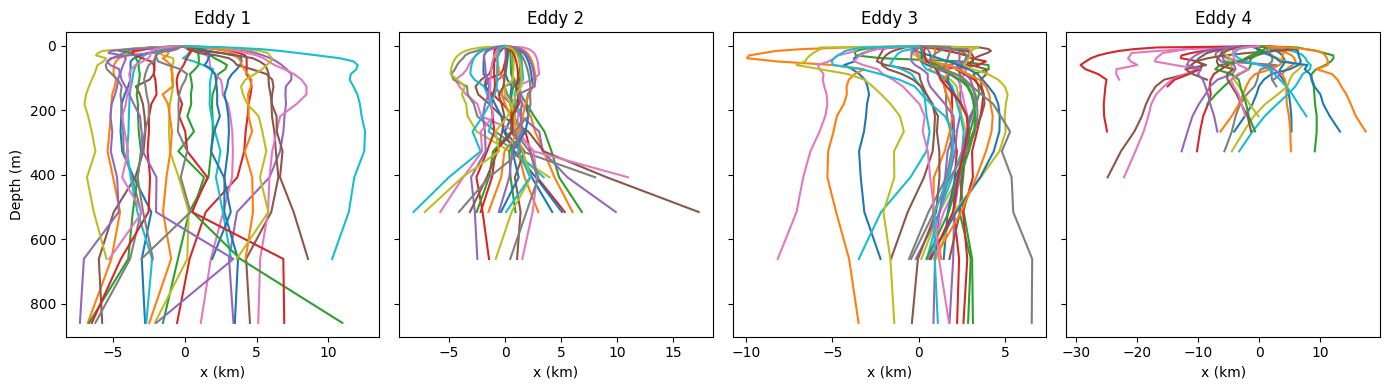

In [35]:
fig, axs = plt.subplots(1, 4, figsize=(14,4), sharey=True)

for i, eddy in enumerate(the_frontier_eddies):

    for t in range(0, 30):
    
        df = df_DOPIOE[(df_DOPIOE['Eddy']==eddy) & (df_DOPIOE['Day']==t)].copy()
        if len(df) > 0:
            df['xc'] -= df.iloc[0]['xc']
            df['yc'] -= df.iloc[0]['yc']
            
            axs[i].plot(df['xc'], -df['Depth'])
            axs[i].set_title(f'Eddy {i+1}')
    
        else:
            print(f'{eddy}, t:{t}')
    
    axs[i].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].invert_yaxis()

plt.tight_layout()
plt.show()

#### ESPRA

In [10]:
def espra(xi, yi, ui, vi):
    from scipy.optimize import least_squares
    if np.any(np.isnan(ui)):
        return np.nan, np.nan, np.array([[np.nan, np.nan], [np.nan, np.nan]]), np.nan
    def residuals(params, x, y, u_i, v_i):
        x0, y0, q11, q12, q22 = params
        u = -2 * q22 * (y - y0) - 2 * q12 * (x - x0)
        v =  2 * q11 * (x - x0) + 2 * q12 * (y - y0)
        return np.concatenate([(u - u_i), (v - v_i)])
    def fit_params(x, y, u_i, v_i):
        x0_init, y0_init = np.mean(x), np.mean(y)
        q11_init, q12_init, q22_init = 1.0, 0.0, 1.0  # Initial guesses
        params_init = [x0_init, y0_init, q11_init, q12_init, q22_init]
        result = least_squares(residuals, params_init, args=(x, y, u_i, v_i))
        return result.x 
    x0, y0, q11, q12, q22 = fit_params(xi, yi, ui, vi)
    w = 2*(q11 + q22)
    Q = np.array([[q11, q12], [q12, q22]])
    return x0, y0, Q, w

In [36]:
df_ESPRA = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'nic', 'njc', 'z', 'Depth', 'w', 'Q'])
for eddy in the_frontier_eddies:

    var = 1 if eddies[eddy].iloc[0]['Vort'] > 0 else -1 # 1 for anti-cyclone

    for t in range(30): 

        U = sample_data[eddy]['T'+str(t)]['U']
        V = sample_data[eddy]['T'+str(t)]['V']
        
        x, y = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
        X, Y, dx = *np.meshgrid(x, y), x[1]-x[0]

        xc_pre, yc_pre = 0, 0
        nic, njc = U.shape[0]//2, U.shape[1]//2
        r = 5 #dx =5km
        for depth_lvl in range(25):

            if not (r <= nic < U.shape[0] - r and r <= njc < U.shape[1] - r):
                break

            u, v = U[:, :, depth_lvl], V[:,:, depth_lvl]

            mask = (np.hypot(X - X[nic, njc], Y - Y[nic, njc]) < r*dx).T
            xi, yi = X[mask], Y[mask]
            ui, vi = u.T[mask], v.T[mask]

            xc, yc, Q, w = espra(xi, yi, ui, vi)

            if not np.isnan(xc) and np.sign(var) == np.sign(w):
                R = np.hypot(xc - xc_pre, yc - yc_pre)
                if (R < 100) and (np.abs(w) >= 0.01):
                    df_ESPRA.loc[len(df_ESPRA)] = {'Eddy': eddy, 'Day': t, 'xc': xc, 'yc': yc, 'nic': nic, 'njc': njc, 'z': depth_lvl, 'Depth': z_r[150, 150, depth_lvl], 'w': w, 'Q': Q}
                    xc_pre, yc_pre = xc, yc

                    nic = np.abs(x - xc).argmin()
                    njc = np.abs(y - yc).argmin()
                    
                else:
                    break
            else:
                break
df_ESPRA

,Eddy,Day,xc,yc,nic,njc,z,Depth,w,Q
0,Eddy790,0,7.083044,-0.731358,49,49,0,-1.783320,0.036388,"[[0.009871053227849626, -0.0012905015410010128..."
1,Eddy790,0,6.324005,0.655593,51,49,1,-5.879627,0.036655,"[[0.00993559161438901, -0.0014387546891147952]..."
2,Eddy790,0,5.789061,1.101772,51,49,2,-10.725783,0.036538,"[[0.009902962270260574, -0.00143029583777619],..."
3,Eddy790,0,5.201934,1.328677,51,49,3,-16.383097,0.036441,"[[0.009870694491319646, -0.0014257445923269057..."
4,Eddy790,0,4.562295,1.339110,51,49,4,-22.925581,0.036309,"[[0.009819952408764652, -0.0014305083532492715..."
...,...,...,...,...,...,...,...,...,...,...
2336,Eddy775,29,4.723010,-2.872597,51,48,11,-105.615538,-0.013468,"[[-0.002231803255803104, -0.001484799082561995..."
2337,Eddy775,29,5.050533,-2.924562,51,48,12,-126.288127,-0.012599,"[[-0.002137966489207889, -0.001406408542011109..."
2338,Eddy775,29,5.603591,-3.323648,51,48,13,-151.065954,-0.012066,"[[-0.0020680727532000134, -0.00132952363743763..."
2339,Eddy775,29,5.971462,-3.479021,51,48,14,-181.264793,-0.011444,"[[-0.002015194169650183, -0.001231949152695676..."


Eddy775, t:13


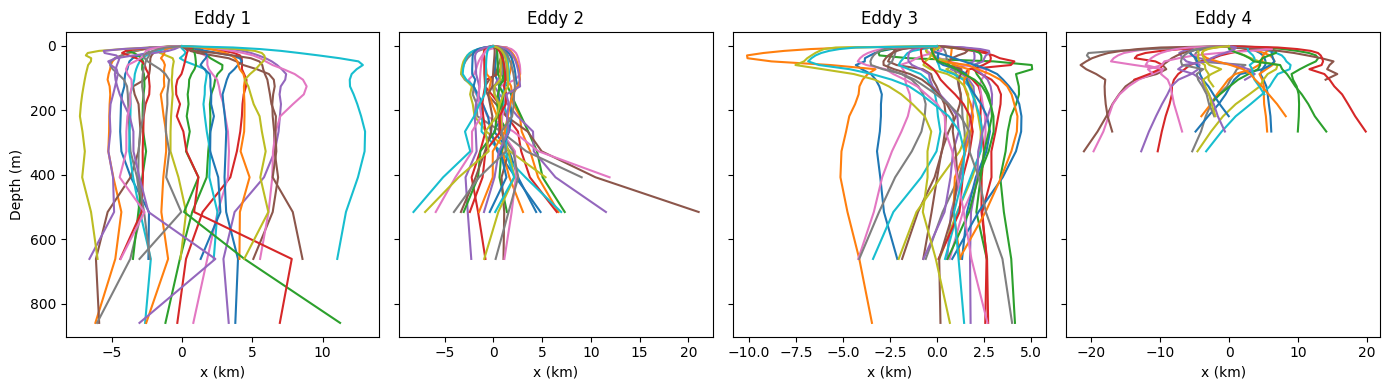

In [37]:
fig, axs = plt.subplots(1, 4, figsize=(14,4), sharey=True)

for i, eddy in enumerate(the_frontier_eddies):

    for t in range(0, 30):
    
        df = df_ESPRA[(df_ESPRA['Eddy']==eddy) & (df_ESPRA['Day']==t)].copy()
        if len(df) > 0:
            df['xc'] -= df.iloc[0]['xc']
            df['yc'] -= df.iloc[0]['yc']
            
            axs[i].plot(df['xc'], -df['Depth'])
            axs[i].set_title(f'Eddy {i+1}')
    
        else:
            print(f'{eddy}, t:{t}')
    
    axs[i].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].invert_yaxis()

plt.tight_layout()
plt.show()

#### COW

In [16]:
def calc_ow(uu, vv, dx, dy):
    WIDTH, LENGTH, SIGMAS = uu.shape
    u_x = (uu[2:,:,:] - uu[:-2,:,:]) / (2*dx)
    u_y = (uu[:,2:,:] - uu[:,:-2,:]) / (2*dy)
    v_x = (vv[2:,:,:] - vv[:-2,:,:]) / (2*dx)
    v_y = (vv[:,2:,:] - vv[:,:-2,:]) / (2*dy)
    u_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), u_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    v_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), v_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    u_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), u_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    v_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), v_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    s_n = u_x - v_y
    s_s = v_x + u_y
    vort = v_x - u_y
    ow = s_n**2 + s_s**2 - vort**2
    return ow
    
def normalize_matrix(matrix, mask_value=np.nan):
    valid_mask = np.where(matrix == mask_value, 0, 1)
    valid_mean = np.nansum(matrix) / np.sum(valid_mask)
    valid_std = np.sqrt(np.nansum(valid_mask * (matrix - valid_mean) ** 2) / np.sum(valid_mask))
    return (matrix - valid_mean) / valid_std

In [17]:
df_COW = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'z', 'Depth', 'SR'])

CS_THRESH = 0.1
OW_THRESH = -.2
RATIO_THRESH = 1/3
SEARCH_RADIUS_MAX = 200

for eddy in the_frontier_eddies:

    for t in range(30): 

        U = sample_data[eddy]['T'+str(t)]['U']
        V = sample_data[eddy]['T'+str(t)]['V']
        
        x, y = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
        X, Y, dx = *np.meshgrid(x, y), x[1]-x[0]
        
        CS = np.hypot(U, V)
        OW = normalize_matrix(calc_ow(U, V, dx, dx))

        bottom_flag = 0
        xc_pre, yc_pre = 0, 0
        for depth_lvl in range(25):

            Search_Radius = 10

            if bottom_flag:
                break

            u, v = U[:, :, depth_lvl], V[:,:, depth_lvl]
            cs, ow = CS[:, :, depth_lvl], OW[:, :, depth_lvl]

            R = np.hypot(X - xc_pre , Y - yc_pre).T 

            while not bottom_flag:
                        
                    mask = (cs < CS_THRESH) & (ow < OW_THRESH) & (R < Search_Radius)
                    
                    potential_centers_ind = np.array(np.where(mask)).T
                    num_pot, num_search = np.sum(mask), np.sum(R < Search_Radius)
        
                    if num_pot == 0:
                        bottom_flag = 1
                        break
                        
                    ratio = num_pot / num_search
                    if ratio <= RATIO_THRESH:
                        A = np.array([[x[i], y[j]] for i, j in potential_centers_ind])
                        xc, yc = np.mean(A, axis=0)

                        R_diff = np.hypot(xc - xc_pre, yc - yc_pre)
                        if R_diff < 100:

                            df_COW.loc[len(df_COW)] = {'Eddy': eddy, 'Day': t, 'xc': xc, 'yc': yc, 'z': depth_lvl, 'Depth': z_r[150, 150, depth_lvl], 'SR': Search_Radius}
                            xc_pre, yc_pre = xc, yc
                            break
                    
                    if Search_Radius >= SEARCH_RADIUS_MAX:
                        bottom_flag = 1
                    else:
                        Search_Radius += 5
df_COW

,Eddy,Day,xc,yc,z,Depth,SR
0,Eddy790,0,6.333333,-1.000000,0,-1.783320,10
1,Eddy790,0,6.272727,1.090909,1,-5.879627,10
2,Eddy790,0,6.000000,1.500000,2,-10.725783,10
3,Eddy790,0,5.454545,1.363636,3,-16.383097,10
4,Eddy790,0,4.500000,1.000000,4,-22.925581,15
...,...,...,...,...,...,...,...
2508,Eddy775,29,2.589744,-1.974359,15,-218.754856,35
2509,Eddy775,29,-1.008621,0.905172,16,-266.206398,35
2510,Eddy775,29,-3.670213,4.468085,17,-327.440851,30
2511,Eddy775,29,-5.240000,8.640000,18,-407.922192,30


Eddy134, t:16
Eddy134, t:19
Eddy134, t:28
Eddy775, t:13


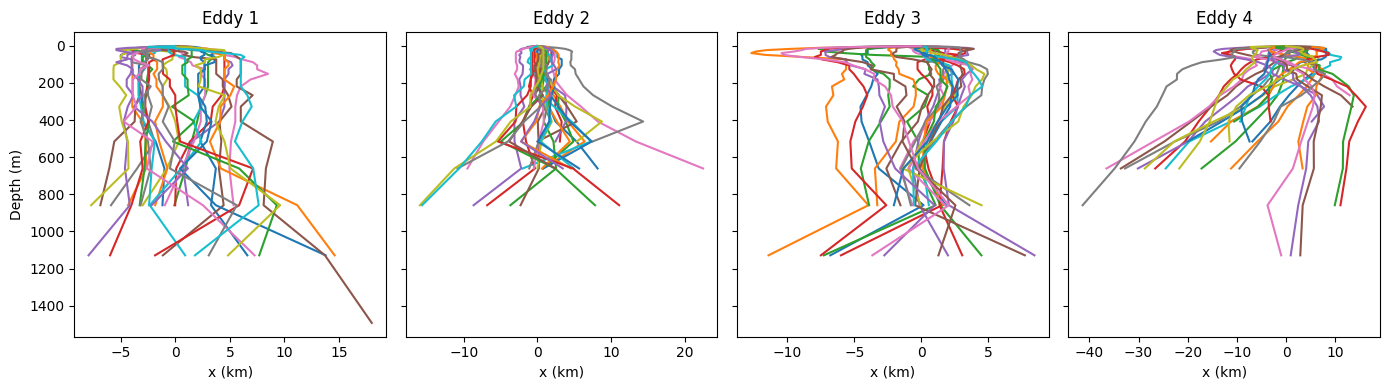

In [32]:
fig, axs = plt.subplots(1, 4, figsize=(14,4), sharey=True)

for i, eddy in enumerate(the_frontier_eddies):

    for t in range(0, 30):
    
        df = df_COW[(df_COW['Eddy']==eddy) & (df_COW['Day']==t)].copy()
        if len(df) > 0:
            df['xc'] -= df.iloc[0]['xc']
            df['yc'] -= df.iloc[0]['yc']
            
            axs[i].plot(df['xc'], -df['Depth'])
            axs[i].set_title(f'Eddy {i+1}')
    
        else:
            print(f'{eddy}, t:{t}')
    
    axs[i].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].invert_yaxis()

plt.tight_layout()
plt.show()

#### LNAM

In [18]:
def calc_lnam(x, y, uu, vv): # remember to input u and v transpose
    b, f = 1, -1
    borders = b + 1
    # L = np.zeros_like(uu)
    L = np.full_like(uu, np.nan)
    for i in range(borders, uu.shape[0] - borders):
        for j in range(borders, uu.shape[1] - borders):
            if not np.isnan(vv[i, j]):
                xlocal = x[i - b:i + b + 1, j - b:j + b + 1]
                ylocal = y[i - b:i + b + 1, j - b:j + b + 1]
                ulocal = uu[i - b:i + b + 1, j - b:j + b + 1]
                vlocal = vv[i - b:i + b + 1, j - b:j + b + 1]
                center_idx = xlocal.shape[0]//2
                d_xcentre = xlocal - xlocal[center_idx, center_idx]
                d_ycentre = ylocal - ylocal[center_idx, center_idx]
                cross = d_xcentre * vlocal - d_ycentre * ulocal
                dot = ulocal * d_xcentre + vlocal * d_ycentre
                produit = np.sqrt(ulocal**2 + vlocal**2) * np.sqrt(d_xcentre**2 + d_ycentre**2)
                sumdp = np.sum(dot) + np.sum(produit)
                if sumdp != 0:
                    L[i, j] = np.sum(cross) / sumdp * np.sign(f)
    return L


In [ ]:
from scipy.ndimage import maximum_filter, minimum_filter

df_LNAM = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'z', 'Depth'])

WINDOW_SIZE = 7
SEARCH_RADIUS = 100
VAR = 1  # 1 for cyclonic

for eddy in the_frontier_eddies:

    var = 1 if eddies[eddy].iloc[0]['Vort'] < 0 else -1

    for t in range(30): 

        U = sample_data[eddy]['T'+str(t)]['U']
        V = sample_data[eddy]['T'+str(t)]['V']
        
        x, y = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
        X, Y, dx = *np.meshgrid(x, y), x[1]-x[0]

        sigma_OW = normalize_matrix(calc_ow(U, V, dx, dx))

        xc_pre, yc_pre = 0, 0
        ic_pre, jc_pre = U.shape[0] // 2, V.shape[1] // 2
        bottom_flag = False
        for depth_lvl in range(25):
            if bottom_flag:
                break

            u, v = U[:, :, depth_lvl], V[:,:, depth_lvl]
            
            IC, JC = np.meshgrid(np.arange(u.shape[0]), np.arange(u.shape[1]))
            R = (np.hypot(ic_pre - IC, jc_pre - JC) * dx).T

            u = np.where(R <= SEARCH_RADIUS, u, np.nan)
            v = np.where(R <= SEARCH_RADIUS, v, np.nan)

            lnam = calc_lnam(X, Y, u.T, v.T).T

            if var == 1:
                extrema = maximum_filter(lnam, size=WINDOW_SIZE, mode='reflect')
            else:
                extrema = minimum_filter(lnam, size=WINDOW_SIZE, mode='reflect')

            positions = (lnam == extrema)
            ic, jc = np.argwhere(positions).T

            if len(ic):
                R = (np.hypot(ic - ic_pre, jc - jc_pre) * dx).T
                idx = np.nanargmin(R)
                ic, jc = ic[idx], jc[idx]

                R_diff = np.hypot(ic - ic_pre, jc - jc_pre) * dx
                if (sigma_OW[ic, jc, depth_lvl] <= -0.2) & (R_diff < 100):
                    df_LNAM.loc[len(df_LNAM)] = {'Eddy': eddy, 'Day': t, 'xc': x[ic], 'yc': y[jc], 'z': depth_lvl, 'Depth': z_r[150, 150, depth_lvl]}
                    xc_pre, yc_pre = xc, yc
                    ic_pre, jc_pre = ic, jc
                else:
                    bottom_flag = True
        if t % 15 == 0:
            print(t)


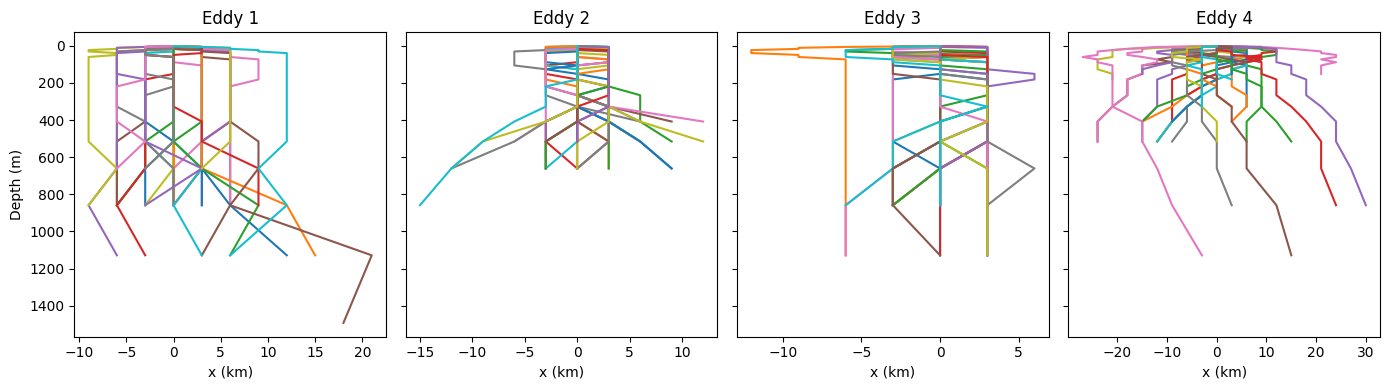

In [33]:
fig, axs = plt.subplots(1, 4, figsize=(14,4), sharey=True)

for i, eddy in enumerate(the_frontier_eddies):

    for t in range(0, 30):
    
        df = df_LNAM[(df_LNAM['Eddy']==eddy) & (df_LNAM['Day']==t)].copy()
        if len(df) > 0:
            df['xc'] -= df.iloc[0]['xc']
            df['yc'] -= df.iloc[0]['yc']
            
            axs[i].plot(df['xc'], -df['Depth'])
            axs[i].set_title(f'Eddy {i+1}')
    
        else:
            print(f'{eddy}, t:{t}')
    
    axs[i].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].invert_yaxis()

plt.tight_layout()
plt.show()

#### Analysis

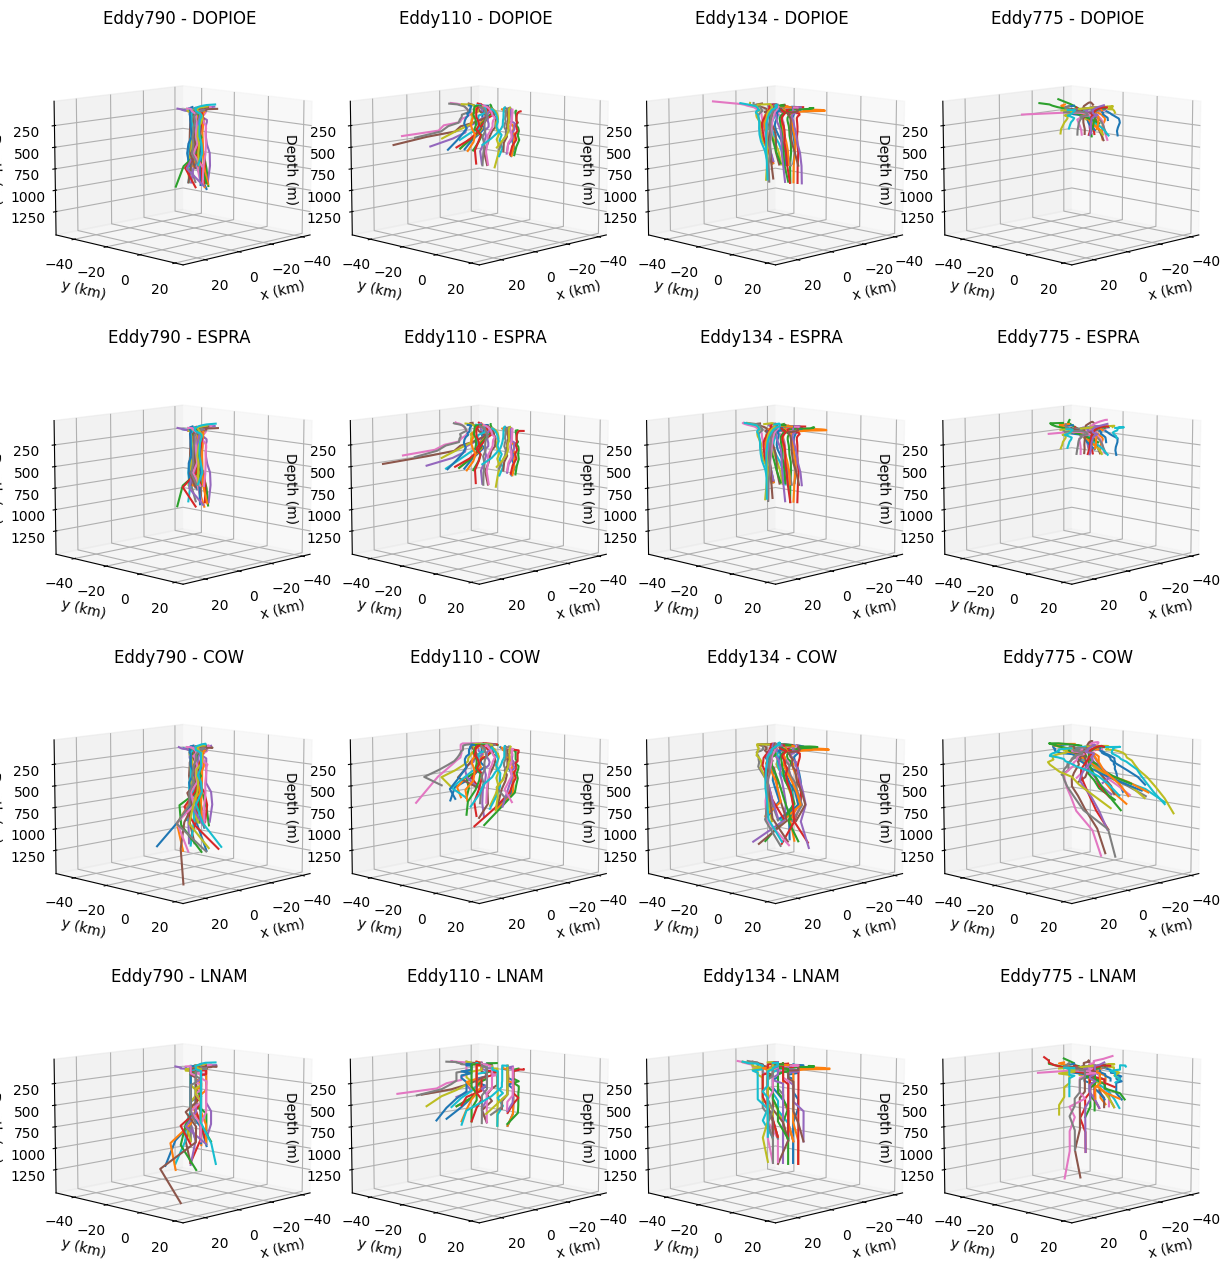

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig, axs = plt.subplots(4, len(the_frontier_eddies), figsize=(12, 13), subplot_kw={'projection': '3d'})
methods = {'DOPIOE': df_DOPIOE, 'ESPRA': df_ESPRA, 'COW': df_COW, 'LNAM': df_LNAM}

# Compute column-wise limits
limits = {eddy: (
    min(df['xc'].min() for df in methods.values() if eddy in df['Eddy'].values),
    max(df['xc'].max() for df in methods.values() if eddy in df['Eddy'].values),
    min(df['yc'].min() for df in methods.values() if eddy in df['Eddy'].values),
    max(df['yc'].max() for df in methods.values() if eddy in df['Eddy'].values),
    -max(df['Depth'].max() for df in methods.values() if eddy in df['Eddy'].values),
    -min(df['Depth'].min() for df in methods.values() if eddy in df['Eddy'].values),
) for eddy in the_frontier_eddies}

# Plot data
for r, (method, df_method) in enumerate(methods.items()):
    for c, eddy in enumerate(the_frontier_eddies):
        ax = axs[r, c]
        for t in range(30):
            df = df_method[(df_method['Eddy'] == eddy) & (df_method['Day'] == t)]
            ax.plot(df['xc'], df['yc'], -df['Depth'])

        ax.set(xlim=limits[eddy][:2], ylim=limits[eddy][2:4], zlim=limits[eddy][4:],
               xlabel="x (km)", ylabel="y (km)", zlabel="Depth (m)", title=f"{eddy} - {method}")
        ax.invert_zaxis()
        ax.view_init(elev=10, azim=45)

plt.tight_layout()
plt.show()

### Clustering Technique

#### Solve the Problem

$$
\huge x' = x\cos\theta - y\sin\theta + a
$$
$$
\huge y' = x\sin\theta + y\cos\theta + b
$$
\
$$
\begin{aligned}
\huge R(a, b, \theta) & \huge = \sum_i \left[x_i'(t_1) - x_i(t_2)\right]^2 + \left[y_i'(t_1) - y_i(t_2)\right]^2 \\
                      & \huge = \sum_i \left[x_i(t_1)\cos\theta - y_i(t_1)\sin\theta + a - x_i(t_2) \right]^2 + \left[x_i(t_1)\sin\theta + y_i(t_1)\cos\theta + b - y_i(t_2)\right]^2
\end{aligned}
$$

In [63]:
def rotate_y_xy(points, theta_deg):
    """Rotate points (x, y) about the y-axis by angle theta (in degrees)."""
    theta = np.deg2rad(theta_deg) 
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    xy_rotated = np.dot(points[:, :2], rotation_matrix.T)
    return np.hstack((xy_rotated, points[:, 2:]))
    

In [90]:
from scipy.optimize import minimize

def cost(params, x_t, y_t, x_ref, y_ref):
    dx, dy, theta = params
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    tx = x_t * cos_theta - y_t * sin_theta + dx
    ty = x_t * sin_theta + y_t * cos_theta + dy
    return np.sum((tx - x_ref)**2 + (ty - y_ref)**2)

def rmse(params, x_t, y_t, x_ref, y_ref):
    dx, dy, theta = params
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    tx = x_t * cos_theta - y_t * sin_theta + dx
    ty = x_t * sin_theta + y_t * cos_theta + dy
    return np.sqrt(np.mean((tx - x_ref)**2 + (ty - y_ref)**2))

methods = {'DOPIOE': df_DOPIOE, 'ESPRA': df_ESPRA, 'COW': df_COW, 'LNAM': df_LNAM}

results = []
for method in methods.keys():
    df = methods[method]
    for eddy, group in df.groupby('Eddy'):
        ref = group[group['Day'] == 14]
        if ref.empty: continue
        x_ref, y_ref = ref.iloc[0]['xc'], ref.iloc[0]['yc']
        for day, day_group in group.groupby('Day'):
            x_t, y_t = day_group['xc'].values, day_group['yc'].values
            res = minimize(lambda p: cost(p, x_t, y_t, x_ref, y_ref), [0, 0, 0],
                           bounds=[(None, None), (None, None), (0, 2*np.pi)])
            if res.success:
                dx, dy, theta = res.x
                results.append({
                    'Eddy': eddy,
                    'Method': method,
                    'Day': day,
                    'theta': np.rad2deg(theta),
                    'dx': dx,
                    'dy': dy,
                    'rmse': rmse(res.x, x_t, y_t, x_ref, y_ref)
                })

df_best_shift = pd.DataFrame(results)
df_best_shift


,Eddy,Method,Day,theta,dx,dy,rmse
0,Eddy110,DOPIOE,0,3.440736,4.595810,11.596311,2.173257
1,Eddy110,DOPIOE,1,3.504877,4.973703,12.302358,3.000162
2,Eddy110,DOPIOE,2,6.038162,5.945657,10.783668,3.764157
3,Eddy110,DOPIOE,3,5.497387,6.335970,13.364155,3.788096
4,Eddy110,DOPIOE,4,3.006709,4.397636,15.004539,5.839622
...,...,...,...,...,...,...,...
467,Eddy790,LNAM,25,0.576900,5.863679,-4.876316,5.217159
468,Eddy790,LNAM,26,2.023007,6.505512,-4.123838,2.089820
469,Eddy790,LNAM,27,33.936205,6.592614,-5.601236,2.602981
470,Eddy790,LNAM,28,3.717709,9.480546,-4.485417,2.109260


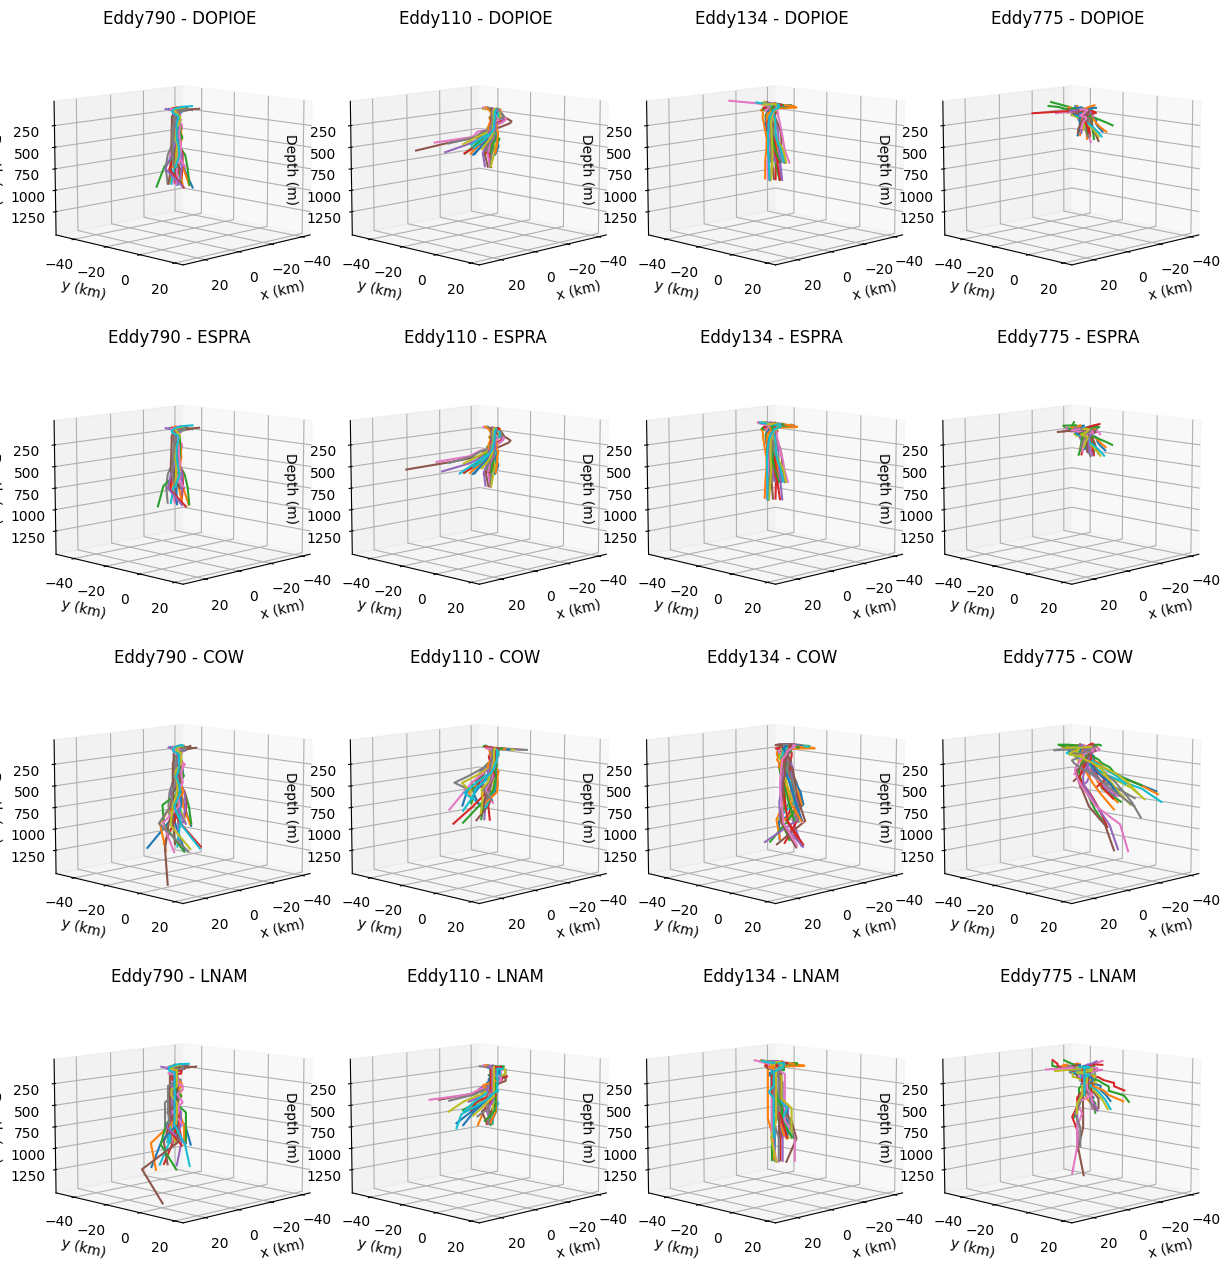

In [94]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig, axs = plt.subplots(4, len(the_frontier_eddies), figsize=(12, 13), subplot_kw={'projection': '3d'})
methods = {'DOPIOE': df_DOPIOE, 'ESPRA': df_ESPRA, 'COW': df_COW, 'LNAM': df_LNAM}

# Compute column-wise limits
limits = {eddy: (
    min(df['xc'].min() for df in methods.values() if eddy in df['Eddy'].values),
    max(df['xc'].max() for df in methods.values() if eddy in df['Eddy'].values),
    min(df['yc'].min() for df in methods.values() if eddy in df['Eddy'].values),
    max(df['yc'].max() for df in methods.values() if eddy in df['Eddy'].values),
    -max(df['Depth'].max() for df in methods.values() if eddy in df['Eddy'].values),
    -min(df['Depth'].min() for df in methods.values() if eddy in df['Eddy'].values),
) for eddy in the_frontier_eddies}

# Plot data
for r, (method, df_method) in enumerate(methods.items()):
    for c, eddy in enumerate(the_frontier_eddies):
        ax = axs[r, c]
        for t in range(30):
            df = df_method[(df_method['Eddy'] == eddy) & (df_method['Day'] == t)]

            if len(df) > 0:

                df_shift_info = df_best_shift[(df_best_shift['Method']==method) &
                                         (df_best_shift['Eddy']==eddy) &
                                         (df_best_shift['Day']==t)]
                dx, dy, theta = df_shift_info['dx'].iloc[0], df_shift_info['dy'].iloc[0], df_shift_info['theta'].iloc[0]
    
                points_rotated = rotate_y_xy(np.column_stack((df['xc'], df['yc'])), theta)
                x_shifted = points_rotated[:, 0] + dx
                y_shifted = points_rotated[:, 1] + dy
                
                ax.plot(x_shifted, y_shifted, -df['Depth'])

        ax.set(xlim=limits[eddy][:2], ylim=limits[eddy][2:4], zlim=limits[eddy][4:],
               xlabel="x (km)", ylabel="y (km)", zlabel="Depth (m)", title=f"{eddy} - {method}")
        ax.invert_zaxis()
        ax.view_init(elev=10, azim=45)

plt.tight_layout()
plt.show()

In [101]:
df_shifted = pd.DataFrame(columns=['Method', 'Eddy', 'Day', 'xc', 'yc', 'Depth'])

methods = {
    'DOPIOE': df_DOPIOE,
    'ESPRA': df_ESPRA,
    'COW': df_COW,
    'LNAM': df_LNAM
}

new_rows = []
for method, df_meth in methods.items():
    for eddy in df_meth['Eddy'].unique():
        for day in df_meth.loc[df_meth['Eddy'] == eddy, 'Day'].unique():
            df_day = df_meth[(df_meth['Eddy'] == eddy) & (df_meth['Day'] == day)]
            df_shift_info = df_best_shift[
                (df_best_shift['Method'] == method) &
                (df_best_shift['Eddy'] == eddy) &
                (df_best_shift['Day'] == day)
            ]
            if not df_shift_info.empty:
                dx, dy, theta = (df_shift_info.iloc[0][['dx', 'dy', 'theta']])
                points_rotated = rotate_y_xy(np.column_stack((df_day['xc'], df_day['yc'])), theta)
                new_df = pd.DataFrame({
                    'Method': [method] * len(df_day),
                    'Eddy': [eddy] * len(df_day),
                    'Day': [day] * len(df_day),
                    'xc': points_rotated[:, 0] + dx,
                    'yc': points_rotated[:, 1] + dy,
                    'Depth': df_day['Depth'].values
                })
                new_rows.append(new_df)

# Concatenate non-empty DataFrames
to_concat = [df for df in [df_shifted] + new_rows if not df.empty]
df_shifted = pd.concat(to_concat, ignore_index=True) if to_concat else pd.DataFrame(columns=['Method', 'Eddy', 'Day', 'xc', 'yc', 'Depth'])

df_shifted


,Method,Eddy,Day,xc,yc,Depth
0,DOPIOE,Eddy790,0,8.863959e+00,-6.821229,-1.783320
1,DOPIOE,Eddy790,0,8.103164e+00,-5.954708,-5.879627
2,DOPIOE,Eddy790,0,7.539607e+00,-5.483191,-10.725783
3,DOPIOE,Eddy790,0,6.927658e+00,-5.218484,-16.383097
4,DOPIOE,Eddy790,0,6.281817e+00,-5.159434,-22.925581
...,...,...,...,...,...,...
9694,LNAM,Eddy775,29,-9.759310e-07,-0.166666,-151.065954
9695,LNAM,Eddy775,29,-9.759310e-07,-0.166666,-181.264793
9696,LNAM,Eddy775,29,-9.759310e-07,-0.166666,-218.754856
9697,LNAM,Eddy775,29,-9.759310e-07,-0.166666,-266.206398


In [146]:
df_list = []
for method in df_shifted['Method'].unique():
    df_meth = df_shifted[df_shifted['Method'] == method].copy()
    for eddy in df_meth['Eddy'].unique():
        df_eddy = df_meth[df_meth['Eddy'] == eddy]
        # Group by 'Depth' and compute both mean and standard deviation for 'xc' and 'yc'
        result = df_eddy.groupby('Depth')[['xc', 'yc']].agg(['mean', 'std']).reset_index()
        # Flatten the MultiIndex columns
        result.columns = ['Depth', 'xc', 'xc_std', 'yc', 'yc_std']
        # Add Method and Eddy info
        result['Method'] = method
        result['Eddy'] = eddy
        result = result[['Method', 'Eddy', 'Depth', 'xc', 'xc_std', 'yc', 'yc_std']]
        if not result.empty:
            df_list.append(result)

df_mean_std = pd.concat(df_list, ignore_index=True)
df_mean_std = df_mean_std.sort_values('Depth', ascending=False)
df_mean_std


,Method,Eddy,Depth,xc,xc_std,yc,yc_std
350,LNAM,Eddy775,-1.783320,1.324050,8.398520,-2.770172,7.620850
282,LNAM,Eddy790,-1.783320,5.255249,3.953351,-4.926291,3.230142
304,LNAM,Eddy110,-1.783320,-0.066386,1.598570,-0.038910,3.498740
21,DOPIOE,Eddy790,-1.783320,5.014218,3.622431,-4.111801,3.047063
83,DOPIOE,Eddy775,-1.783320,3.997115,7.819940,-0.940013,7.388853
...,...,...,...,...,...,...,...
328,LNAM,Eddy775,-1128.898331,14.478250,0.737835,10.173935,3.873684
305,LNAM,Eddy134,-1128.898331,-5.054014,2.092775,-10.015809,2.607987
260,LNAM,Eddy790,-1128.898331,10.291306,6.349915,-7.993787,4.604133
167,COW,Eddy790,-1492.971178,17.131915,NaN,0.490590,NaN


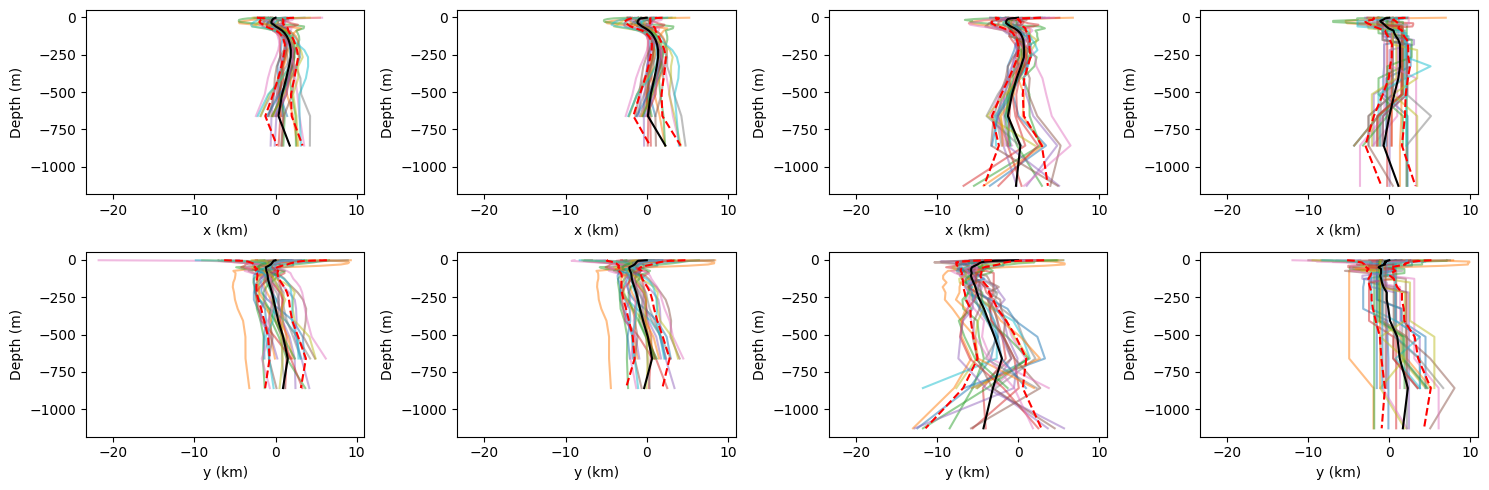

In [160]:
eddy = the_frontier_eddies[2]

fig, axs = plt.subplots(2, 4, figsize=(15,5))

df_eddy = df_shifted[df_shifted['Eddy']==eddy].copy()
for k, method in enumerate(df_eddy['Method'].unique()):
    df_meth = df_eddy[df_eddy['Method']==method]
    df_av = df_mean_std[(df_mean_std['Method']==method)&(df_mean_std['Eddy']==eddy)]
    for day in df_meth['Day'].unique():
        df = df_meth[df_meth['Day']==day]
        axs[0,k].plot(df['xc']-df_av['xc'].iloc[0], df['Depth'], alpha=.5)
        axs[1,k].plot(df['yc']-df_av['yc'].iloc[0], df['Depth'], alpha=.5)
    
    axs[0,k].plot(df_av['xc']-df_av['xc'].iloc[0], df_av['Depth'], color='k')
    axs[0,k].plot(df_av['xc']-df_av['xc'].iloc[0] + df_av['xc_std'], df_av['Depth'], '--r')
    axs[0,k].plot(df_av['xc']-df_av['xc'].iloc[0] - df_av['xc_std'], df_av['Depth'], '--r')
    
    axs[1,k].plot(df_av['yc']-df_av['yc'].iloc[0], df_av['Depth'], color='k')
    axs[1,k].plot(df_av['yc']-df_av['yc'].iloc[0] + df_av['yc_std'], df_av['Depth'], '--r')
    axs[1,k].plot(df_av['yc']-df_av['yc'].iloc[0] - df_av['yc_std'], df_av['Depth'], '--r')

    axs[0,k].set_xlabel('x (km)')
    axs[0,k].set_ylabel('Depth (m)')
    axs[1,k].set_xlabel('y (km)')
    axs[1,k].set_ylabel('Depth (m)')

all_axes = axs.flatten()
ymin = min(ax.get_ylim()[0] for ax in all_axes)
xmin = min(ax.get_xlim()[0] for ax in all_axes)
xmax = max(ax.get_xlim()[1] for ax in all_axes)
for ax in all_axes:
    ax.set_ylim(ymin, 50)
    ax.set_xlim(xmin, xmax)

plt.tight_layout()
plt.show()